In [1]:
import os
project_root = os.pardir
import sys
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)

import updated_deg_flows as udf
from data import make_dataset_classes as dat
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
lfn = dat.LFN('1996-1997', show_info=False)
A, B = udf.UpdatedDegreeFlowMatrix(lfn, year=1997)

In [53]:
'''
Take the matrix of flows and create a new matrix where the rows
and columns now corresponds to logarithmically scalled bins.
'''

#create the bins
#set the logarithmic bin width
#nb, log bin width b defined such that log(x_i+1) = log(x_i) + b
#so x_i+1 = x_i*e^b
#and the width of bin (i, i+1) w = x_i*(e^b-1)
#so the width of a bin is proportional to its lower limit
b = 0.5
#create container of bin edges and set first two edges to 0 and 1
bin_edges = np.array([-0.01, 1])
#add further bin edges until the upper limit is greater than the
#largest value in the flow matrix
upper_limit = A.shape[0]
assert upper_limit > 1
#set current bin edge to 1
bin_edge = 1
while bin_edge <= upper_limit:
    bin_edge = bin_edge * np.exp(b)
    bin_edges = np.append(bin_edges, bin_edge)
    print(bin_edge)
    if len(bin_edges) > 100:
        print('Too many bins')
        break

1.6487212707
2.71828182846
4.48168907034
7.38905609893
12.1824939607
20.0855369232
33.1154519587
54.5981500331
90.0171313005
148.413159103
244.691932264
403.428793493
665.141633044


In [54]:
degs = [lfn.UpdatedDegree(node) for node in lfn.graph.nodes()]

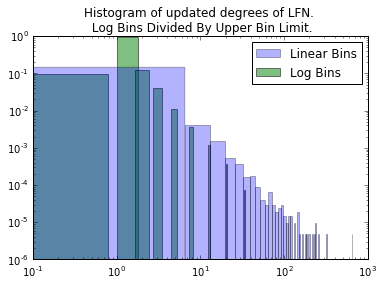

In [58]:
freq, bins = np.histogram(degs, bin_edges)
for i in range(len(freq)):
    freq[i] = freq[i]/float(bins[i+1])
s = 0
for i in range(len(bins)-1):
    x = bins[i+1] - bins[i]
    y = x*freq[i]
    s += y
freq = freq/float(s)
plt.bar(bins[:-1], freq, label='Log Bins', alpha=0.5, color='green')
plt.hist(degs, bins=100, label='Linear Bins', alpha=0.3, color='blue', normed=True)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('Histogram of updated degrees of LFN. \n Log Bins Divided By Upper Bin Limit.')
plt.savefig(os.path.join(project_root, 'reports', 'figures', 'Histogram of updated degrees of LFN_logscale_bins_normalised.png'))

In [52]:
bin_edges

array([-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01,
       -0.01, -0.01, -0.01, -0.01, -0.01, -0.01])

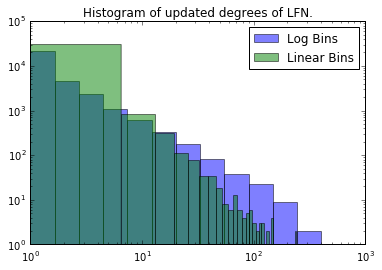

In [15]:
lh = plt.hist(degs, bins=bin_edges, label='Log Bins', alpha=0.5)
plt.hist(degs, bins=100, label='Linear Bins', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.title('Histogram of updated degrees of LFN.')
plt.legend()
plt.savefig(os.path.join(project_root, 'reports', 'figures', 'Histogram of updated degrees of LFN_logscale_bins'))